In [2]:
import numpy as np 
import pandas as pd 

## Loading required packages

In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from keras.models import Model
import cv2
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam

In [8]:
df = pd.read_csv('D:/New folder (2)/Car Insurance Prediction/Dataset/train.csv')
df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0


## Loading testing data

In [9]:
df_test = pd.read_csv('D:/New folder (2)/Car Insurance Prediction/Dataset/test.csv')
df_test

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage
0,img_4538519.jpg,B,23600,590.0,2025-04-12,5978.00
1,img_7766002.jpg,C,28300,707.5,2028-08-24,7153.00
2,img_4637390.jpg,AC,43700,1092.5,2023-11-28,11003.00
3,img_4516108.jpg,BB,46100,1152.5,2028-02-04,11603.00
4,img_4517008.jpg,BB,40700,1017.5,2022-01-03,10253.00
...,...,...,...,...,...,...
595,img_7766518.jpg,B,30900,772.5,2024-10-23,7803.00
596,img_4535713.jpg,O,51300,1282.5,2025-02-21,12903.00
597,img_4511787.jpg,BQ,27000,675.0,2023-07-13,23527.68
598,img_4517592.jpg,AA,42600,1065.0,2024-05-05,10728.00


EDA

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.monospace'] = 'Ubunto Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (16,10)



C:\Users\Raman\AppData\Local\Temp/ipykernel_10888/2774494682.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr,dtype=np.bool)


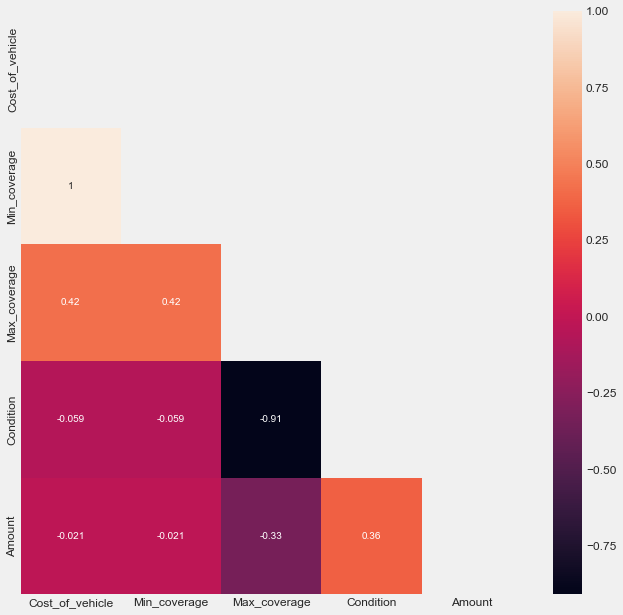

In [11]:
corr = df.corr()
plt.figure(figsize=(10,10))
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask,annot=True)
plt.show()

<AxesSubplot:>

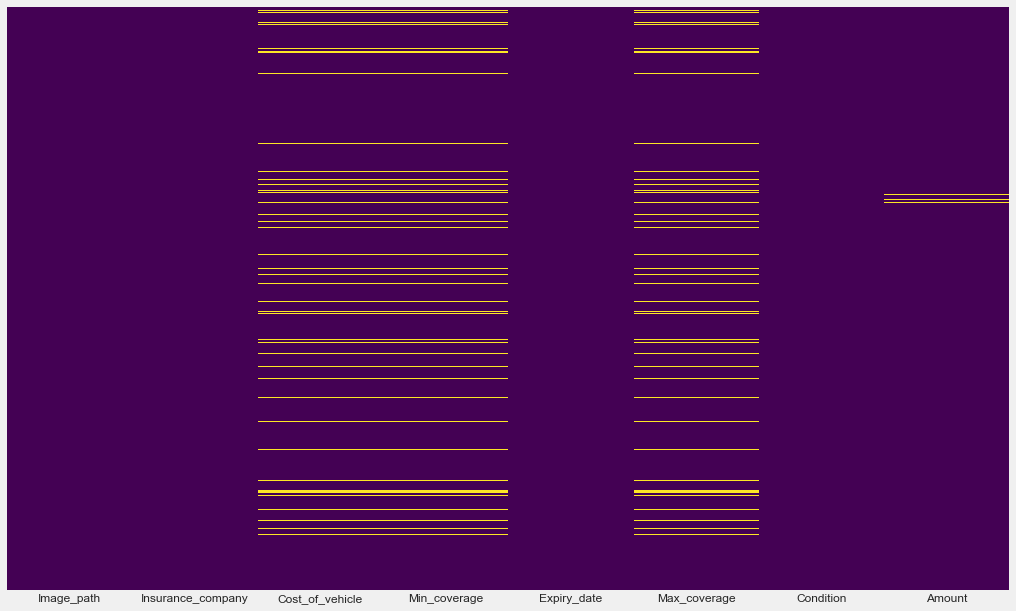

In [12]:
## Showing which feature got missing values
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

<AxesSubplot:>

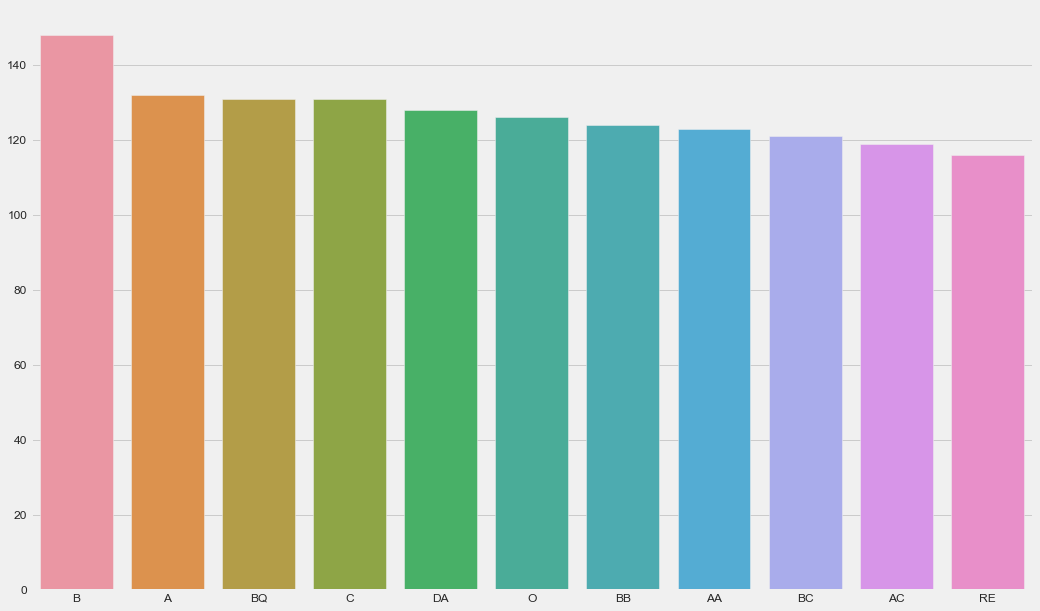

In [13]:
x = list(df['Insurance_company'].value_counts().keys())
y = df['Insurance_company'].value_counts().values
sns.barplot(x= x,y=y)

<AxesSubplot:ylabel='Density'>

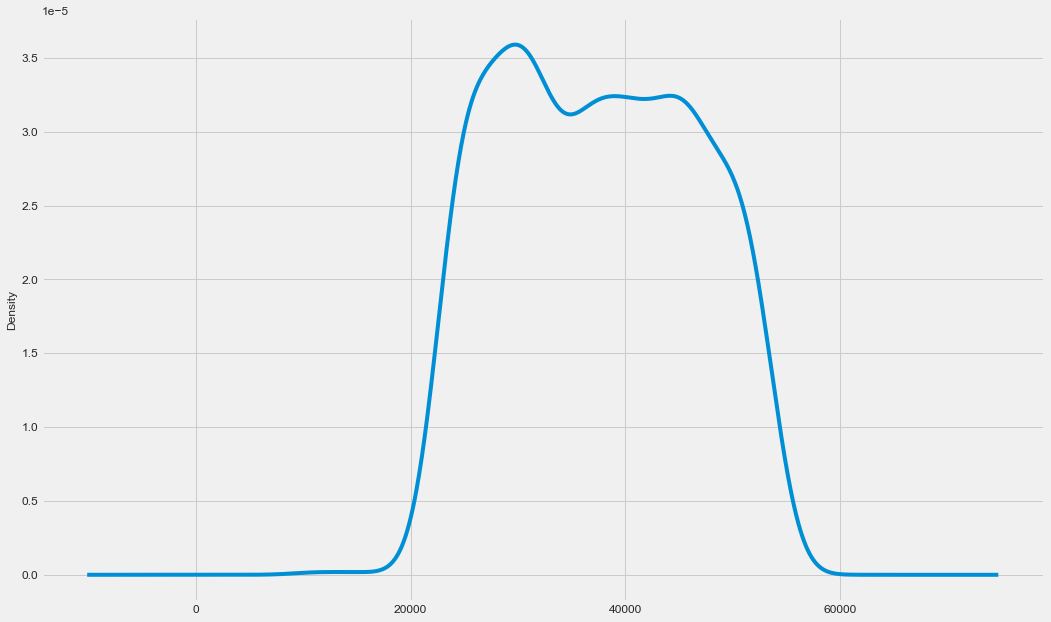

In [14]:
df['Cost_of_vehicle'].plot(kind='kde')

<AxesSubplot:xlabel='Max_coverage', ylabel='Amount'>

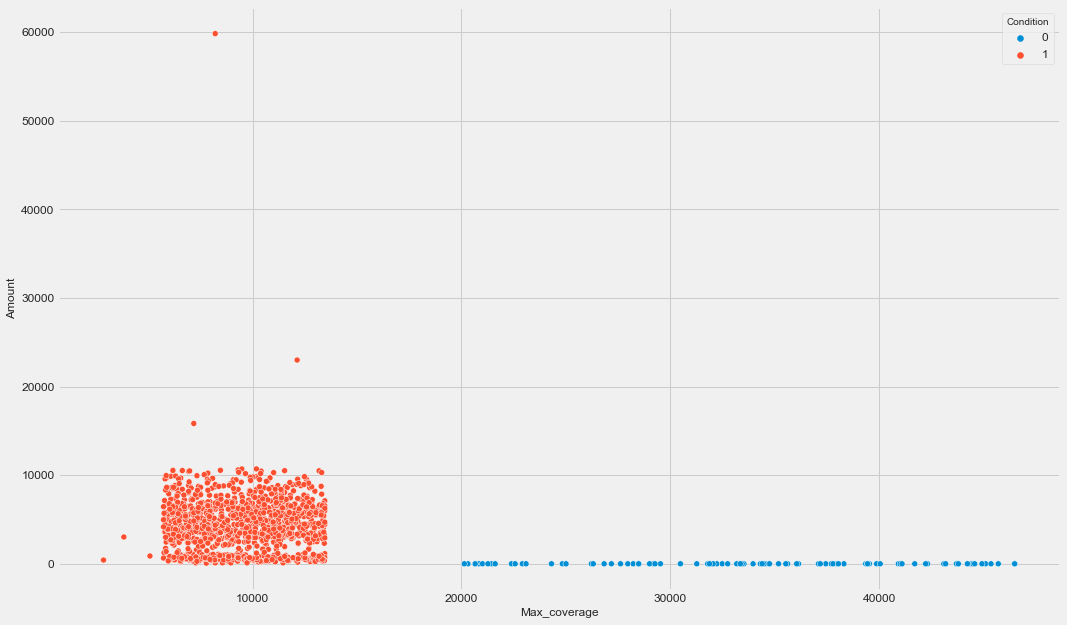

In [15]:
## scatterplot between feature 'Max_coverage' ,and feature 'Amount' with label of feature 'Condition'
sns.scatterplot(x ='Max_coverage' ,y='Amount',hue='Condition',data=df)

<AxesSubplot:xlabel='Condition', ylabel='Amount'>

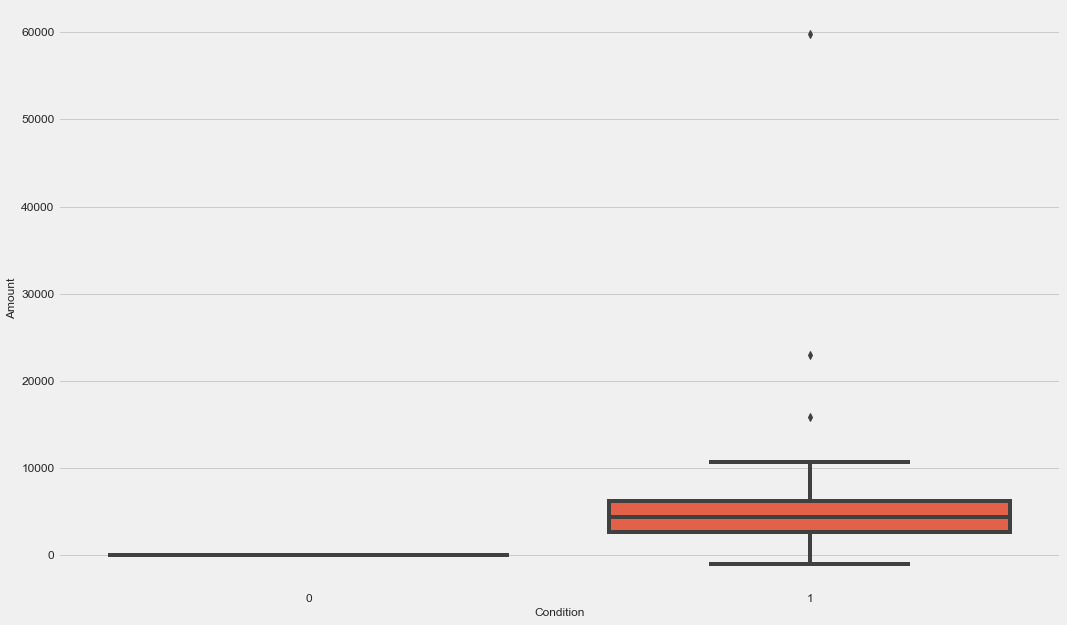

In [16]:
sns.boxplot(y='Amount',x='Condition',data=df)

<AxesSubplot:>

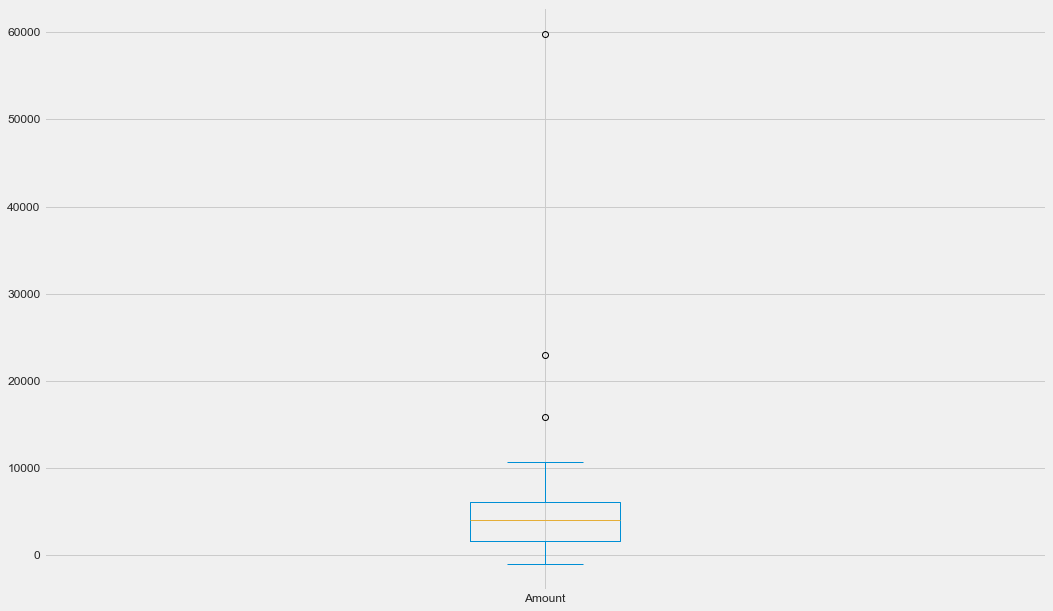

In [17]:
df['Amount'].plot(kind='box')

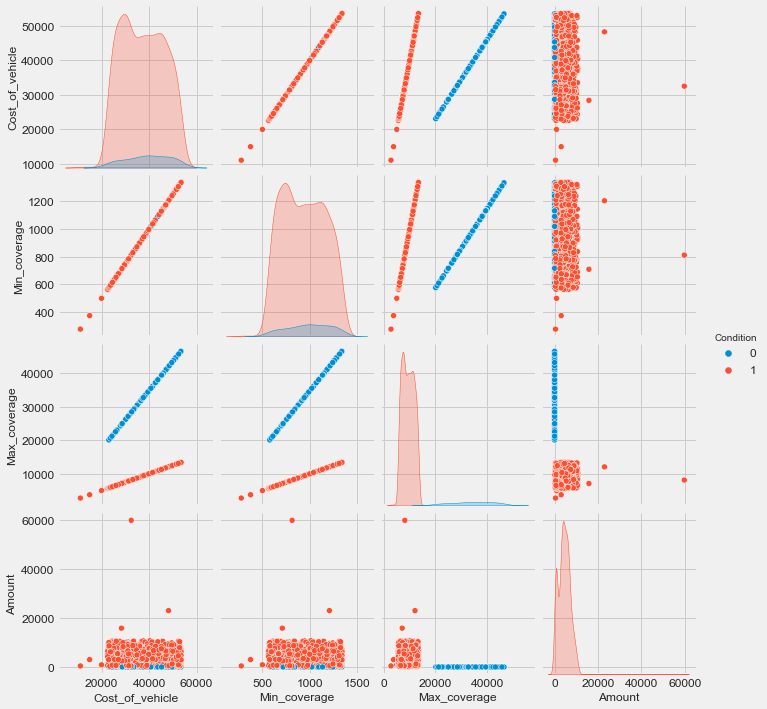

In [18]:
sns.pairplot(df,diag_kind='kde',hue='Condition')


In [19]:
## Separating damaged vehicles data



target_df = df[df['Condition'] == 1]
target_df.index = range(target_df.shape[0])
target_df

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.0,1,6194.0
1,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.0,1,7699.0
2,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.0,1,8849.0
3,img_4537770.jpg,AC,50700.0,1267.5,2026-08-07,12753.0,1,253.0
4,img_7765649.jpg,AC,53200.0,1330.0,2028-01-12,13378.0,1,4013.0
...,...,...,...,...,...,...,...,...
1295,img_4637237.jpg,DA,52300.0,1307.5,2025-02-17,13153.0,1,4565.0
1296,img_4637000.jpg,BQ,41500.0,1037.5,2023-12-30,10453.0,1,3363.0
1297,img_4637503.jpg,AA,31400.0,785.0,2022-11-25,7928.0,1,5336.0
1298,img_4515101.jpg,A,33200.0,830.0,2022-10-10,8378.0,1,8734.0


<AxesSubplot:>

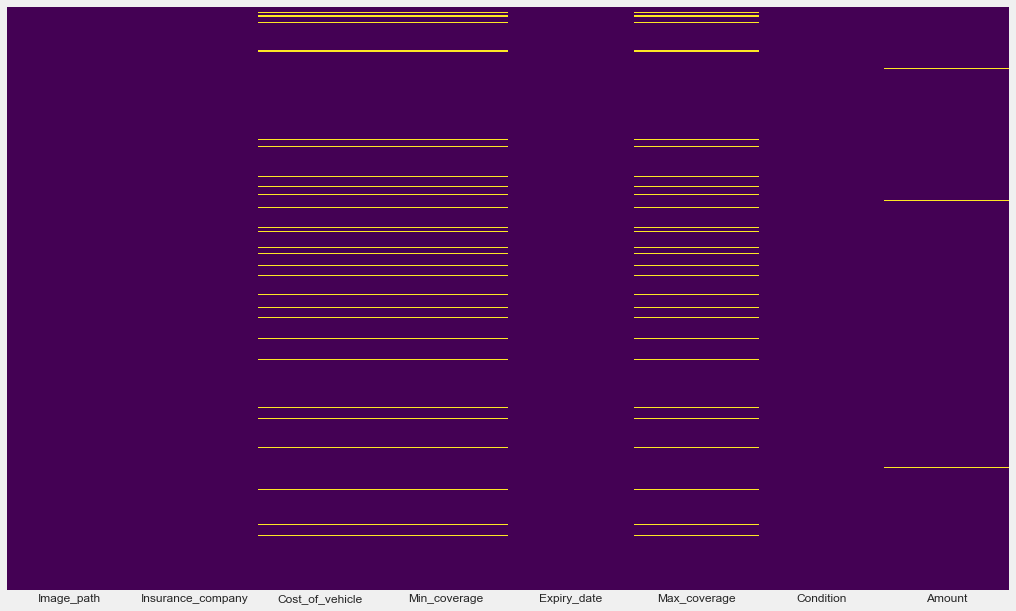

In [20]:
## Visulaizing the missing values

sns.heatmap(target_df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

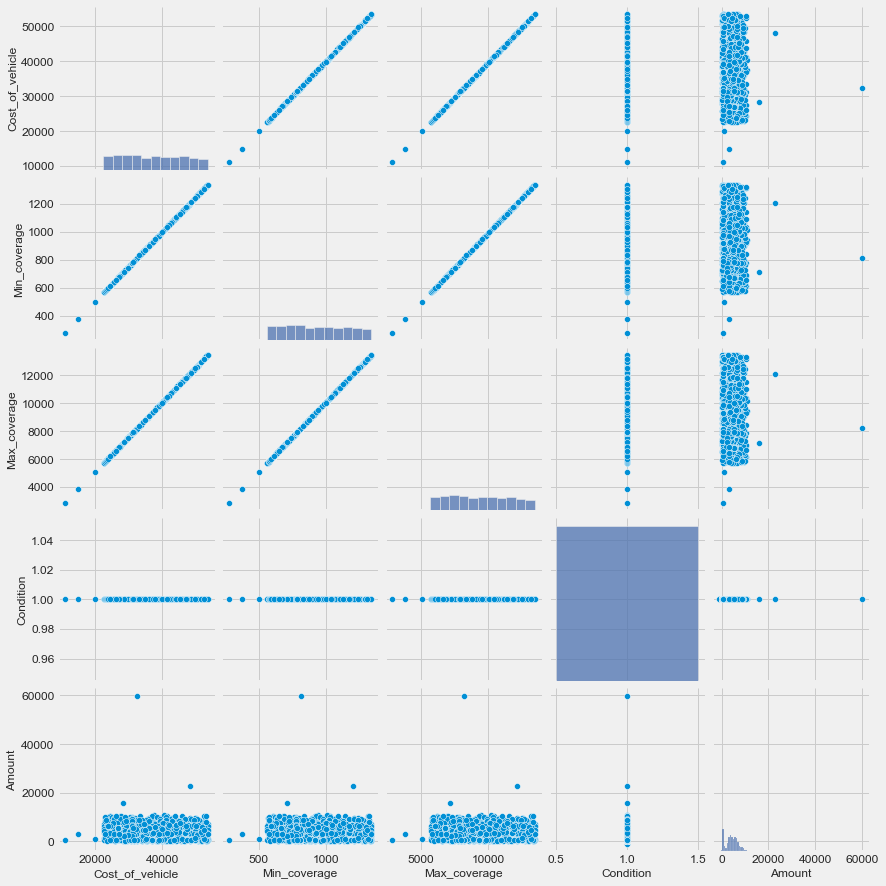

In [21]:
sns.pairplot(target_df)

C:\Users\Raman\AppData\Local\Temp/ipykernel_10888/3051965376.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr,dtype=np.bool)


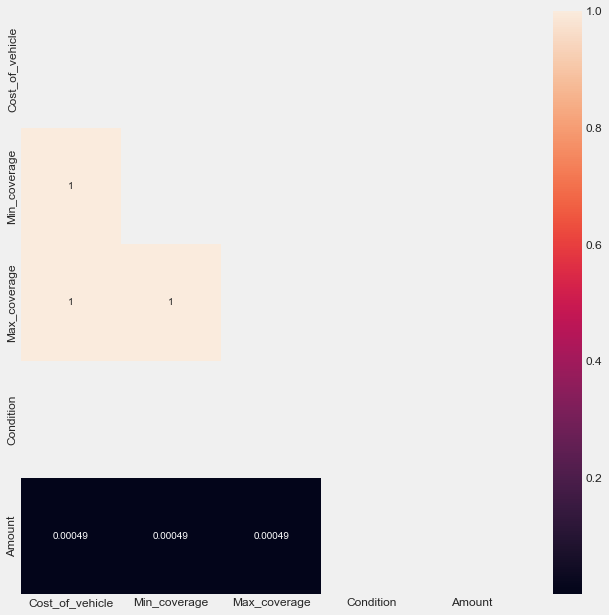

In [22]:
corr = target_df.corr()
plt.figure(figsize=(10,10))
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask,annot=True)
plt.show()

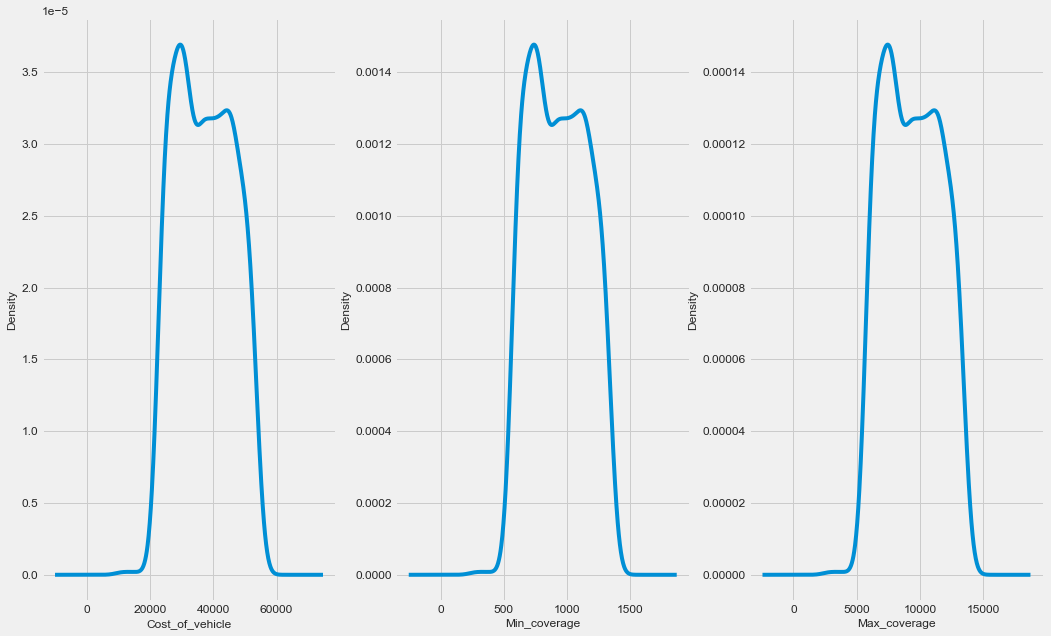

In [23]:
plt.figure()
ax0 = plt.subplot(1,3,1)
ax1 = plt.subplot(1,3,2)
ax2 = plt.subplot(1,3,3)
target_df['Cost_of_vehicle'].plot(kind='kde',ax=ax0)
ax0.set_xlabel('Cost_of_vehicle')
target_df['Min_coverage'].plot(kind='kde',ax=ax1)
ax1.set_xlabel('Min_coverage')
target_df['Max_coverage'].plot(kind='kde',ax=ax2)
ax2.set_xlabel('Max_coverage')
plt.show()

<AxesSubplot:>

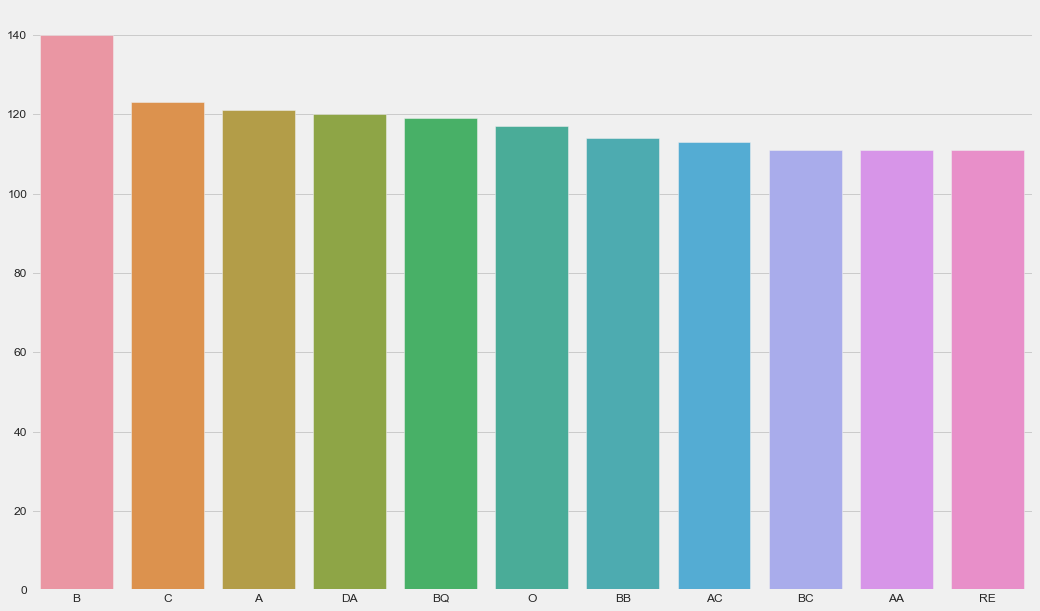

In [24]:
x = list(target_df['Insurance_company'].value_counts().keys())
y = target_df['Insurance_company'].value_counts().values
sns.barplot(x= x,y=y)

## Pre-processing

In [25]:
# Get the number of missing data points per column
missing_values_count_train = df.isnull().sum()
print(missing_values_count_train)

Image_path            0
Insurance_company     0
Cost_of_vehicle      89
Min_coverage         89
Expiry_date           0
Max_coverage         89
Condition             0
Amount               11
dtype: int64


In [26]:
# Get the number of missing data points per column
missing_values_count_test = df_test.isnull().sum()
print(missing_values_count_test)

Image_path           0
Insurance_company    0
Cost_of_vehicle      0
Min_coverage         0
Expiry_date          0
Max_coverage         0
dtype: int64


In [27]:
# Filling missing values
df = df.fillna(method='bfill', axis=0).fillna(0)

In [28]:
# Checking different values in Insurance company in the training set
df['Insurance_company'].value_counts()

B     148
A     132
BQ    131
C     131
DA    128
O     126
BB    124
AA    123
BC    121
AC    119
RE    116
Name: Insurance_company, dtype: int64

In [29]:
# Checking different values in Insurance company in the testing set
df_test['Insurance_company'].value_counts()

BB    67
AA    62
C     60
A     60
B     59
RE    54
BQ    52
AC    50
O     50
BC    43
DA    43
Name: Insurance_company, dtype: int64

# Label encoding and scaling

In [31]:
features_num = ['Cost_of_vehicle', 'Min_coverage', 'Max_coverage']
features_cat = ['Insurance_company']

le= LabelEncoder()   
df['Insurance_company'] = le.fit_transform(df['Insurance_company'])
df_test['Insurance_company'] = le.transform(df_test['Insurance_company'])

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
)

y = df['Amount']
train_imputed = df.loc[:,['Cost_of_vehicle', 'Min_coverage', 'Max_coverage', 'Insurance_company']]
X = preprocessor.fit_transform(train_imputed)

test_imputed = df_test.loc[:,['Cost_of_vehicle', 'Min_coverage',  'Max_coverage', 'Insurance_company']]
test_X = preprocessor.transform(test_imputed)

train_imputed.columns

Index(['Cost_of_vehicle', 'Min_coverage', 'Max_coverage', 'Insurance_company'], dtype='object')

In [32]:
#Train-test split
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1,test_size=0.2)

## Train a random forest regressor

In [33]:
rf_model = RandomForestRegressor(random_state=1, n_estimators = 1000, max_depth=3)
# fit your model
rf_model.fit(train_X,train_y)
val_preds = rf_model.predict(val_X)
# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(val_y,val_preds)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

Validation MAE for Random Forest Model: 2050.061640924192


Training for Xg boost classifier

In [34]:
import xgboost
from xgboost import XGBRegressor

regression_model = XGBRegressor(random_state=1, n_estimators = 1000, max_depth=3)
regression_model.fit(train_X, train_y)
predictions = regression_model.predict(val_X)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,val_y )))

Mean Absolute Error: 2275.934163457155


Cat boost Regressor

In [35]:
from catboost import CatBoostRegressor
import sklearn.metrics as metrics 
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
clf = CatBoostRegressor(random_state=1, n_estimators = 1000, max_depth=3)
clf.fit(train_X, train_y)
predictions = clf.predict(val_X)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,val_y )))


Learning rate set to 0.041677
0:	learn: 3182.0550625	total: 192ms	remaining: 3m 11s
1:	learn: 3168.3221585	total: 196ms	remaining: 1m 37s
2:	learn: 3155.3470515	total: 199ms	remaining: 1m 6s
3:	learn: 3143.0584888	total: 203ms	remaining: 50.4s
4:	learn: 3132.0515580	total: 206ms	remaining: 40.9s
5:	learn: 3122.3428960	total: 209ms	remaining: 34.7s
6:	learn: 3114.2692154	total: 213ms	remaining: 30.2s
7:	learn: 3105.0398952	total: 214ms	remaining: 26.6s
8:	learn: 3097.3060750	total: 216ms	remaining: 23.7s
9:	learn: 3089.5504620	total: 217ms	remaining: 21.5s
10:	learn: 3082.9718321	total: 218ms	remaining: 19.6s
11:	learn: 3076.4505719	total: 219ms	remaining: 18s
12:	learn: 3070.0598608	total: 221ms	remaining: 16.7s
13:	learn: 3063.6590453	total: 222ms	remaining: 15.6s
14:	learn: 3058.2016375	total: 223ms	remaining: 14.7s
15:	learn: 3053.0871390	total: 225ms	remaining: 13.8s
16:	learn: 3049.1473278	total: 226ms	remaining: 13.1s
17:	learn: 3044.9046962	total: 228ms	remaining: 12.4s
18:	lear

## Get the predictions for amount

In [36]:
amount_predictions = rf_model.predict(test_X)

In [37]:
amount_predictions1 = regression_model.predict(test_X)

In [38]:
amount_predictions1= clf.predict(test_X)

## Prepare the images

In [39]:
X = df.loc[:,['Image_path']]
y = df.loc[:,['Condition']]    
X_test = df.loc[:,['Image_path']]
print('train set shape:', X.shape)
print('test set shape:', X_test.shape)

train set shape: (1399, 1)
test set shape: (1399, 1)
